In [16]:
mnist.train.num_examples

55000

In [28]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the 'License');
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an 'AS IS' BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""A simple MNIST classifier which displays summaries in TensorBoard.
This is an unimpressive MNIST model, but it is a good example of using
tf.name_scope to make a graph legible in the TensorBoard graph explorer, and of
naming summary tags so that they are grouped meaningfully in TensorBoard.
It demonstrates the functionality of every TensorBoard dashboard.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os
import sys

import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data

class FLAGS:
    max_steps = 3000
    learning_rate = 0.001
    dropout = 1.0
    fake_data = False
    data_dir =os.path.join(os.getenv('TEST_TMPDIR', '/tmp'),
                             'tensorflow/mnist/input_data')
    log_dir = os.path.join(os.getenv('TEST_TMPDIR', '/tmp'),
                               'tensorflow/mnist/logs/mnist_with_summaries')
    
# Import data
mnist = input_data.read_data_sets(FLAGS.data_dir,
                                fake_data=FLAGS.fake_data)


Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz


In [41]:
tf.reset_default_graph() # THIS IS NECESSARY BEFORE MAKING NEW SESSION TO STOP IT ERRORING!!

if tf.gfile.Exists(FLAGS.log_dir):
    tf.gfile.DeleteRecursively(FLAGS.log_dir)
tf.gfile.MakeDirs(FLAGS.log_dir)

sess = tf.InteractiveSession()
# Create a multilayer model.



# Input placeholders
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, 784], name='x-input')
    y_ = tf.placeholder(tf.int64, [None], name='y-input')

with tf.name_scope('input_reshape'):
    image_shaped_input = tf.reshape(x, [-1, 28, 28, 1])
#     xsh = tf.reshape(image_shaped_input, [-1, 14*14])
    tf.summary.image('input', image_shaped_input, 10)

# We can't initialize these variables to 0 - the network will get stuck.
def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
      mean = tf.reduce_mean(var)
      tf.summary.scalar('mean', mean)
      with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
      tf.summary.scalar('stddev', stddev)
      tf.summary.scalar('max', tf.reduce_max(var))
      tf.summary.scalar('min', tf.reduce_min(var))
      tf.summary.histogram('histogram', var)

def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    """Reusable code for making a simple neural net layer.
    It does a matrix multiply, bias add, and then uses ReLU to nonlinearize.
    It also sets up name scoping so that the resultant graph is easy to read,
    and adds a number of summary ops.
    """
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
      # This Variable will hold the state of the weights for the layer
      with tf.name_scope('weights'):
        weights = weight_variable([input_dim, output_dim])
        variable_summaries(weights)
      with tf.name_scope('biases'):
        biases = bias_variable([output_dim])
        variable_summaries(biases)
      with tf.name_scope('Wx_plus_b'):
        preactivate = tf.matmul(input_tensor, weights) + biases
        tf.summary.histogram('pre_activations', preactivate)
      activations = act(preactivate, name='activation')
      tf.summary.histogram('activations', activations)
      return activations

hidden1 = nn_layer(x, 784, 10, 'layer1',tf.sigmoid)

with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)
    tf.summary.scalar('dropout_keep_probability', keep_prob)
    dropped = tf.nn.dropout(hidden1, keep_prob)

# Do not apply softmax activation yet, see below.
y = nn_layer(hidden1, 784, 10, 'layer2', act=tf.identity)

with tf.name_scope('cross_entropy'):
    # The raw formulation of cross-entropy,
    #
    # tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.softmax(y)),
    #                               reduction_indices=[1]))
    #
    # can be numerically unstable.
    #
    # So here we use tf.losses.sparse_softmax_cross_entropy on the
    # raw logit outputs of the nn_layer above, and then average across
    # the batch.
    with tf.name_scope('total'):
      cross_entropy = tf.losses.sparse_softmax_cross_entropy(
          labels=y_, logits=y)
    tf.summary.scalar('cross_entropy', cross_entropy)

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(FLAGS.learning_rate).minimize(
        cross_entropy)

with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
      correct_prediction = tf.equal(tf.argmax(y, 1), y_)
    with tf.name_scope('prediction'):
      prediction = tf.argmax(y, 1)
    with tf.name_scope('accuracy'):
      accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

# Merge all the summaries and write them out to
# /tmp/tensorflow/mnist/logs/mnist_with_summaries (by default)
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(FLAGS.log_dir + '/train', sess.graph)
test_writer = tf.summary.FileWriter(FLAGS.log_dir + '/test')
tf.global_variables_initializer().run()

# Train the model, and also write summaries.
# Every 10th step, measure test-set accuracy, and write test summaries
# All other steps, run train_step on training data, & add training summaries

def feed_dict(train):
    """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
    if train or FLAGS.fake_data:
      xs, ys = mnist.train.next_batch(100, fake_data=FLAGS.fake_data)
      k = FLAGS.dropout
    else:
      xs, ys = mnist.test.images, mnist.test.labels
      k = 1.0
    return {x: xs, y_: ys, keep_prob: k}

for i in range(FLAGS.max_steps):
    if i % 10 == 0:  # Record summaries and test-set accuracy
      summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict(False))
      test_writer.add_summary(summary, i)
      print('Accuracy at step %s: %s' % (i, acc))
    else:  # Record train set summaries, and train
      if i % 100 == 99:  # Record execution stats
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        summary, _ = sess.run([merged, train_step],
                              feed_dict=feed_dict(True),
                              options=run_options,
                              run_metadata=run_metadata)
        train_writer.add_run_metadata(run_metadata, 'step%03d' % i)
        train_writer.add_summary(summary, i)
        print('Adding run metadata for', i)
      else:  # Record a summary
        summary, _ = sess.run([merged, train_step], feed_dict=feed_dict(True))
        train_writer.add_summary(summary, i)
train_writer.flush()
train_writer.close()
test_writer.flush()
test_writer.close()




TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("dropout/Placeholder:0", dtype=float32) is not an element of this graph.

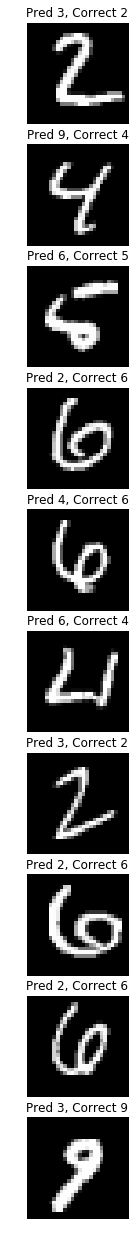

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

gts, ims, cpreds,preds = sess.run([y_, image_shaped_input,correct_prediction, prediction], feed_dict=feed_dict(False))
npreds = np.logical_not(cpreds)

fig, axes = plt.subplots(10,1,figsize=[2,22])

for i, (im,pred,gt) in enumerate(zip(ims[npreds],preds[npreds],gts[npreds])):
    
    axes[i].imshow(im.squeeze(),cmap='gray') 
    axes[i].axis('off')
    axes[i].set_title("Pred {}, Correct {}".format(pred,gt))

    if i == 9:
        break
        
